# Setting

In [164]:
import numpy as np
import random 
import os
import sys
import pandas as pd
from tqdm import tqdm

import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

In [165]:
import tensorflow as tf 

from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate,AveragePooling1D
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping

from keras.optimizers import Adam, RMSprop

## From here:

In [166]:
TUNING_MODE = 'OFF' # ON/OFF
LOSS_FUNCTION = 'mse'

do_the_mcdropout_wc = True
do_the_mcdropout = True

METRIC = 'MAE'  # MAE/MSE

OPTIMIZER = 'adam' # adam, rmsprop
LR = 0.001   #adam과 rmsprop의 defaut값
BATCH_SIZE = 64
EPOCHS = 600

PATIENCE = 30 # Early-stopping-round
#-------아직 구현 안 된 부분-------

DECAY_RATE=0.2
DECAY_STEP=200

# Import Data

In [167]:
data_path = './data/'
output_path = './output/'

In [168]:
data_train = np.load(data_path + 'data_train.npy')
data_train_FGS = np.load(data_path + 'data_train_FGS.npy')

data_test = np.load(data_path + 'data_test.npy')
data_test_FGS = np.load(data_path + 'data_test_FGS.npy')

train_solution = np.loadtxt(data_path + 'train_labels.csv', delimiter=',', skiprows=1)

data_train.shape, data_train_FGS.shape, data_test.shape, data_test_FGS.shape, train_solution.shape

((673, 187, 282, 32),
 (673, 187, 32, 32),
 (1, 187, 282, 32),
 (1, 187, 32, 32),
 (673, 284))

# Preprocessing

순서 
1. `train_solution` 처리하기
2. `data_train_FGS`, `data_test_FGS`를 y축 방향으로 sum 하기
3. AIRS 데이터와 FGS data concat하여 `dataset_train`, `dataset_test` 만들기
4. concat한 거 z축에 대해 sum
5. `dataset_train`, `dataset_test`를 Star Flux기준으로 normalize하기
6. Transpose
7. Trainset을 Train, Validset으로 쪼개기
8. Transpose - Time축 align을 위해 
9. In-Transit data 추출
10. Mean Flux 빼기
11. 데이터를 [0, 1] 범위로 Normalize
12. Reshape for CNN
13. Prepare Target

### 1. `train_solution`처리

In [169]:
targets = train_solution[:,1:] # planet_id 제거
targets_mean = targets[:, 1:].mean(axis=1) # targets의 sum값 도출
N = len(targets) #데이터셋 수

### 2. `data_train_FGS`, `data_test_FGS`를 y축 방향으로 sum

In [170]:
train_FGS_column = data_train_FGS.sum(axis=2)
test_FGS_column = data_test_FGS.sum(axis=2)

train_FGS_column.shape, test_FGS_column.shape

((673, 187, 32), (1, 187, 32))

### 3. AIRS 데이터와 FGS 데이터 concat해서 dataset_train, dataset_test 만들기

In [171]:
dataset_train = np.concatenate([data_train, train_FGS_column[:,:,np.newaxis, :]], axis=2)
dataset_test = np.concatenate([data_test, test_FGS_column[:,:,np.newaxis, :]], axis=2)

In [172]:
dataset_train.shape, dataset_test.shape

((673, 187, 283, 32), (1, 187, 283, 32))

### 4. concat한 거 z축에 대해 sum

In [173]:
dataset_train = dataset_train.sum(axis=3)
dataset_test = dataset_test.sum(axis=3)

In [174]:
dataset_train.shape, dataset_test.shape

((673, 187, 283), (1, 187, 283))

### 5. Star Flux로 normalize

In [175]:
def norm_star_spectrum(signal):
    img_star = signal[:,:50].mean(axis=1) + signal[:,-50:].mean(axis=1)
    return signal/img_star[:,np.newaxis, :]

dataset_train_norm = norm_star_spectrum(dataset_train)
dataset_test_norm = norm_star_spectrum(dataset_test)

In [176]:
dataset_train_norm.shape, dataset_test_norm.shape

((673, 187, 283), (1, 187, 283))

 나중에 EDA 하면서 이 부분 분포 한 번 확인해보는게 좋을 듯

In [177]:
dataset_train_norm.max(), dataset_train_norm.min(), dataset_test_norm.max(), dataset_test_norm.min()

(0.523922187938402,
 0.47892563373920166,
 0.5080812205990374,
 0.49110629280505286)

### 6. Transpose

(데이터수, 파장, time축) 순으로 정렬

In [178]:
dataset_train_norm = np.transpose(dataset_train_norm, (0,2,1))
dataset_test_norm = np.transpose(dataset_test_norm, (0,2,1))
dataset_train_norm.shape, dataset_test_norm.shape

((673, 283, 187), (1, 283, 187))

### 7. Trainset, Validset으로 쪼개기

In [179]:
def split(data, N_train_rate):
    total_size = len(data)
    N_train = int(N_train_rate * len(data))
    indices = np.arange(total_size)
    np.random.shuffle(indices)
    train_indices = indices[:N_train]
    valid_indices = indices[N_train:]
    data_train = data[train_indices]
    data_valid = data[valid_indices]
    return data_train, data_valid, train_indices, valid_indices

train_obs, valid_obs, train_indices, valid_indices = split(dataset_train_norm, 0.8)   # 8:2 비율로 split

train_targets = targets[train_indices]
valid_targets = targets[valid_indices]

train_obs.shape, valid_obs.shape, len(train_indices), len(valid_indices), train_targets.shape, valid_targets.shape

((538, 283, 187), (135, 283, 187), 538, 135, (538, 283), (135, 283))

### 8. Transpose - Time축 align을 위해 transpose

In [180]:
train_obs = train_obs.transpose(0, 2, 1)
valid_obs = valid_obs.transpose(0, 2, 1)
test_obs = dataset_test_norm.transpose(0, 2, 1)

train_obs.shape, valid_obs.shape, test_obs.shape

((538, 187, 283), (135, 187, 283), (1, 187, 283))

형태: (데이터 수, time, 파장)

### 9. In-Transit data 추출

In-Transit observation이란: 천문에서 행성이 이동하는 모습을 관측하는 걸 뜻함.

In [181]:
def suppress_out_transit(data, ingress, egress):
    return data[:, ingress:egress, :]

ingress = 75
egress = 115

train_obs_in = suppress_out_transit(train_obs, ingress, egress)
valid_obs_in = suppress_out_transit(valid_obs, ingress, egress)
test_obs_in = suppress_out_transit(test_obs, ingress, egress)

train_obs_in.shape, valid_obs_in.shape, test_obs_in.shape

((538, 40, 283), (135, 40, 283), (1, 40, 283))

### 10. Flux의 mean값 추출

In [182]:
def substract_data_mean(data):
    data_mean = np.zeros(data.shape)
    for i in range(data.shape[0]):
        data_mean[i] = data[i] - data[i].mean()
    return data_mean
train_obs_mean_substracted = substract_data_mean(train_obs_in)
valid_obs_mean_substracted = substract_data_mean(valid_obs_in)
test_obs_mean_substracted = substract_data_mean(test_obs_in)

train_obs_mean_substracted.shape, valid_obs_mean_substracted.shape, test_obs_mean_substracted.shape

((538, 40, 283), (135, 40, 283), (1, 40, 283))

### 11. Normalize data btw [0, 1]

mean값을 normalize

In [183]:
def data_normalize(train_data, valid_data, test_data):
    max_abs_value = max( np.abs(train_data).max(), np.abs(valid_data).max()) #trainset 전체에서 array값 중 최댓값 찾음.
    train_data_norm = train_data / max_abs_value
    valid_data_norm = valid_data / max_abs_value
    test_data_norm = test_data / max_abs_value
    return train_data_norm, valid_data_norm, test_data_norm, max_abs_value

train_obs_norm, valid_obs_norm, test_obs_norm, data_abs_max = data_normalize(train_obs_mean_substracted, 
                                                                            valid_obs_mean_substracted,
                                                                            test_obs_mean_substracted)

train_obs_norm.shape, valid_obs_norm.shape, test_obs_norm.shape, data_abs_max

((538, 40, 283), (135, 40, 283), (1, 40, 283), 0.018263497290595287)

In [184]:
li = [train_obs_norm, valid_obs_norm, test_obs_norm]
for df in li:
    print(f"max: {df.max()}, min: {df.min()}")

max: 0.986144701480468, min: -1.0
max: 0.9061498237972687, min: -0.869643688699163
max: 0.3757097550611997, min: -0.4135140726124283


### 12. Reshape Data for CNN

In [185]:
train_obs_norm = train_obs_norm[..., np.newaxis]
valid_obs_norm = valid_obs_norm[..., np.newaxis]
test_obs_norm = test_obs_norm[..., np.newaxis]

train_obs_norm.shape, valid_obs_norm.shape, test_obs_norm.shape

((538, 40, 283, 1), (135, 40, 283, 1), (1, 40, 283, 1))

### 13. Prepare `target`, `target_mean`

** 이거 logscale로 predict하는게 더 좋을 것 같음. 한 번 고려해볼 것.

#### transmit depth 계산

In [186]:
train_targets_mean = targets_mean[train_indices]
valid_targets_mean = targets_mean[valid_indices]

In [187]:
def suppress_mean(targets, mean):
    return targets - mean[:, np.newaxis]

train_targets_shift = suppress_mean(train_targets, train_targets_mean)
valid_targets_shift = suppress_mean(valid_targets, valid_targets_mean)
train_targets_shift.shape, valid_targets_shift.shape

((538, 283), (135, 283))

In [188]:
train_targets_shift.max(), train_targets_shift.min(), valid_targets_shift.max(), valid_targets_shift.min()

(0.0030516885275461087,
 -0.0014803250975050915,
 0.0011953957057951425,
 -0.0007132791981548578)

#### Normalize

In [189]:
def target_normalize(train_targets, valid_targets):
    max_abs_value = max(np.abs(train_targets).max(), np.abs(valid_targets).max())
    train_targets_norm = train_targets / max_abs_value
    valid_targets_norm = valid_targets / max_abs_value
    return train_targets_norm, valid_targets_norm, max_abs_value

train_targets_norm, valid_targets_norm, target_abs_max = target_normalize(train_targets_shift, valid_targets_shift)

In [190]:
train_targets_norm.shape, valid_targets_norm.shape

((538, 283), (135, 283))

# Model train

### Define

In [191]:
input_obs = Input((40,283,1))
x = Conv2D(32, (3, 1), activation='relu', padding='same')(input_obs)
x = MaxPooling2D((2, 1))(x)
x = BatchNormalization() (x)
x = Conv2D(64, (3, 1), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 1))(x)
x = Conv2D(128, (3, 1), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 1))(x)
x = Conv2D(256, (3, 1), activation='relu', padding='same')(x)
x = Conv2D(32, (1, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((1, 2))(x)
x = BatchNormalization() (x)
x = Conv2D(64, (1, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((1, 2))(x)
x = Conv2D(128, (1, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((1, 2))(x)
x = Conv2D(256, (1, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((1, 2))(x)
x = Flatten()(x)
# DNN
x = Dense(700, activation='relu')(x)
x = Dropout(0.2)(x, training = True)
output = Dense(283, activation='linear')(x)


In [192]:
model = Model(inputs=[input_obs], outputs=output)
checkpoint_filepath = 'output/model_2dcnn.keras'
model_ckt = ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch",
)

if OPTIMIZER =='sgd':
    optimizer = SGD(LR)
elif OPTIMIZER == 'rmsprop':
    optimizer = RMSprop(LR)
elif OPTIMIZER == 'adam':
    optimizer = Adam(LR)

if METRIC == 'MAE':
    metrics = MeanAbsoluteError()
elif METRIC == 'MSE':
    metrics = MeanSqurareError()
    
model.compile(optimizer=optimizer, loss=LOSS_FUNCTION, metrics=[metrics])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 40, 283, 1)]      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 40, 283, 32)       128       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 20, 283, 32)      0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Batc  (None, 20, 283, 32)      128       
 hNormalization)                                                 
                                                                 
 conv2d_17 (Conv2D)          (None, 20, 283, 64)       6208      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 10, 283, 64)      0   

In [193]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    restore_best_weights=True
)

### Train Model

In [194]:
history = model.fit(
     x = train_obs_norm,  
     y = train_targets_norm,
     validation_data = (valid_obs_norm, valid_targets_norm),  
     batch_size=BATCH_SIZE,
     epochs= EPOCHS,
     shuffle=True,
     verbose=0,
    callbacks=[model_ckt, early_stopping]
 )

### Model Eval

#### Learning curve

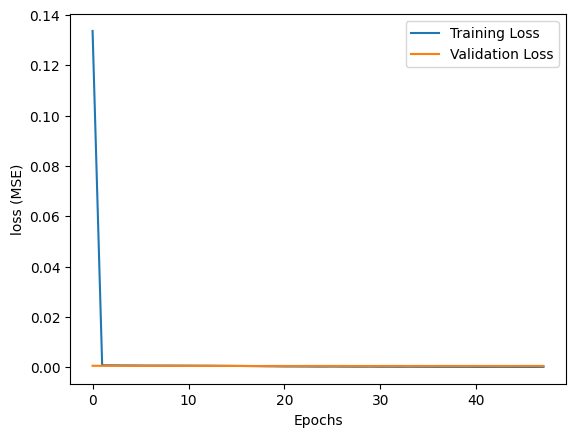

In [195]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss,  label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('loss (MSE)')
plt.legend()
plt.show()

#### MSE

In [196]:
final_training_mse = loss[-1]
final_validation_mse = val_loss[-1]

print(f'Final Training MSE: {final_training_mse}')


Final Training MSE: 0.0002134950627805665


# Load Model, Testset

완성한 모델, testset 저장해두기. *이후 `model_concat`에서 부를 예정*

In [200]:
model.save(output_path+'model_cnn2d.h5')


In [198]:
np.save(output_path+'testset_2d.npy', test_obs_norm)